In [170]:
import numpy as np          
import pandas as pd        
import scipy as sp          
import scipy.stats as stats
import scipy.optimize as op
import scipy.signal as sig
import statistics as stat
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob           

from scipy.stats import gaussian_kde
from numpy import mean
from statistics import stdev
from numpy.fft import rfft, rfftfreq

import time
import sys
import math
import struct
%matplotlib inline

In [171]:
#
# how to run this
#this analysis is done for janurary data 2015 at apachipoint
#1: you will need the level 1 files in min: you can find it in ap046 > level1 > 2015, the GGP fils in there are in min
#you will need to download it, open it, open the file as txt and save it as txt. 
#2: you will need to load them at the locations shown below, and everything should be done.
#
#wher to find the calibration number to convert V to nms^-2
#you will need to go to ap046 > level 1 folder, there are two calibration files in that folder along with 2009-2018 data folders
#in the file IGETS-SG-CAL-ap046-20210300.cal, you can find the gcal value of -944.3833 on the last row, which was applied since 20130908, that is the one we are using.

In [172]:
samplingRate = 1/60   #500000 = 500000  measurements per second, 1 measurement every 0.000002s

In [173]:
file_pattern = r"C:\Users\booker\projects\2015lev3\2015\IGETS-SG-RESMIN-ap046-2015*.txt"
file_paths = glob.glob(file_pattern)

lev3_list = []
for file_path in file_paths:
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=19, names=["yyyymmdd", "hhmmss", "res_fil", "res_nofil", "tides", "rotation", "atm_load", "drift", "g_fil", "p_fil"])
    lev3_list.append(df)

# Concatenate all DataFrames into a single DataFrame
lev3 = pd.concat(lev3_list, ignore_index=True)
lev3

,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,20150101,0.0,15.247,15.247,261.625,-8.787,19.899,2639.658,2927.642,-6.428
1,20150101,100.0,15.097,15.097,255.020,-8.787,19.942,2639.658,2920.930,-6.448
2,20150101,200.0,14.861,14.861,248.385,-8.787,20.052,2639.659,2914.170,-6.499
3,20150101,300.0,14.798,14.798,241.720,-8.787,20.062,2639.659,2907.452,-6.505
4,20150101,400.0,15.026,15.026,235.024,-8.787,19.932,2639.659,2900.854,-6.448
...,...,...,...,...,...,...,...,...,...,...
525619,20151231,235700.0,60.842,60.842,-235.869,-13.297,10.644,2730.633,2552.953,-2.898
525620,20151231,235800.0,60.810,60.810,-236.354,-13.296,10.667,2730.633,2552.460,-2.908
525621,20151231,235900.0,60.824,60.824,-236.818,-13.296,10.713,2730.633,2552.056,-2.928
525622,88888888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
df_bad_3 = lev3.loc[(lev3["p_fil"] == 'nan')| (lev3["g_fil"] == 'nan') | (lev3["hhmmss"] == 'nan')| (lev3["yyyymmdd"] == 99999999)|(lev3["yyyymmdd"] == 88888888) ]#find bad column
bad_index_3 = df_bad_3.index.tolist()#make them into list
lev3 = lev3.drop(lev3.index[bad_index_3])#remove bad rows
lev3 = lev3.reset_index()
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,0,20150101,0.0,15.247,15.247,261.625,-8.787,19.899,2639.658,2927.642,-6.428
1,1,20150101,100.0,15.097,15.097,255.020,-8.787,19.942,2639.658,2920.930,-6.448
2,2,20150101,200.0,14.861,14.861,248.385,-8.787,20.052,2639.659,2914.170,-6.499
3,3,20150101,300.0,14.798,14.798,241.720,-8.787,20.062,2639.659,2907.452,-6.505
4,4,20150101,400.0,15.026,15.026,235.024,-8.787,19.932,2639.659,2900.854,-6.448
...,...,...,...,...,...,...,...,...,...,...,...
525595,525617,20151231,235500.0,60.784,60.784,-234.835,-13.297,10.617,2730.633,2553.902,-2.888
525596,525618,20151231,235600.0,60.856,60.856,-235.363,-13.297,10.633,2730.633,2553.462,-2.894
525597,525619,20151231,235700.0,60.842,60.842,-235.869,-13.297,10.644,2730.633,2552.953,-2.898
525598,525620,20151231,235800.0,60.810,60.810,-236.354,-13.296,10.667,2730.633,2552.460,-2.908


In [175]:
print (lev3["hhmmss"])

0              0.0
1            100.0
2            200.0
3            300.0
4            400.0
            ...   
525595    235500.0
525596    235600.0
525597    235700.0
525598    235800.0
525599    235900.0
Name: hhmmss, Length: 525600, dtype: float64


In [176]:
# Assuming 'lev3' is your DataFrame

# Split 'hhmmss' column into separate components
lev3['hours'] = lev3['hhmmss'] // 10000
lev3['minutes'] = (lev3['hhmmss'] // 100) % 100
lev3['seconds'] = lev3['hhmmss'] % 100

# Calculate total minutes
lev3['minutes_only'] = lev3['hours'] * 60 + lev3['minutes']

print(lev3['minutes_only'])

0            0.0
1            1.0
2            2.0
3            3.0
4            4.0
           ...  
525595    1435.0
525596    1436.0
525597    1437.0
525598    1438.0
525599    1439.0
Name: minutes_only, Length: 525600, dtype: float64


In [177]:
# Assuming 'lev3' is your DataFrame

# Convert 'yyyymmdd' column to datetime format
lev3['date'] = pd.to_datetime(lev3['yyyymmdd'], format='%Y%m%d')

# Define the starting date
starting_date = pd.to_datetime('20150101', format='%Y%m%d')

# Calculate the timedelta from the starting date
lev3['elapsed_minutes'] = (lev3['date'] - starting_date).dt.total_seconds() // 60

print(lev3['elapsed_minutes'])

0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
            ...   
525595    524160.0
525596    524160.0
525597    524160.0
525598    524160.0
525599    524160.0
Name: elapsed_minutes, Length: 525600, dtype: float64


In [178]:
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil,hours,minutes,seconds,minutes_only,date,elapsed_minutes
0,0,20150101,0.0,15.247,15.247,261.625,-8.787,19.899,2639.658,2927.642,-6.428,0.0,0.0,0.0,0.0,2015-01-01,0.0
1,1,20150101,100.0,15.097,15.097,255.020,-8.787,19.942,2639.658,2920.930,-6.448,0.0,1.0,0.0,1.0,2015-01-01,0.0
2,2,20150101,200.0,14.861,14.861,248.385,-8.787,20.052,2639.659,2914.170,-6.499,0.0,2.0,0.0,2.0,2015-01-01,0.0
3,3,20150101,300.0,14.798,14.798,241.720,-8.787,20.062,2639.659,2907.452,-6.505,0.0,3.0,0.0,3.0,2015-01-01,0.0
4,4,20150101,400.0,15.026,15.026,235.024,-8.787,19.932,2639.659,2900.854,-6.448,0.0,4.0,0.0,4.0,2015-01-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,525617,20151231,235500.0,60.784,60.784,-234.835,-13.297,10.617,2730.633,2553.902,-2.888,23.0,55.0,0.0,1435.0,2015-12-31,524160.0
525596,525618,20151231,235600.0,60.856,60.856,-235.363,-13.297,10.633,2730.633,2553.462,-2.894,23.0,56.0,0.0,1436.0,2015-12-31,524160.0
525597,525619,20151231,235700.0,60.842,60.842,-235.869,-13.297,10.644,2730.633,2552.953,-2.898,23.0,57.0,0.0,1437.0,2015-12-31,524160.0
525598,525620,20151231,235800.0,60.810,60.810,-236.354,-13.296,10.667,2730.633,2552.460,-2.908,23.0,58.0,0.0,1438.0,2015-12-31,524160.0


In [179]:
lev3['total_minutes']=lev3['elapsed_minutes']+lev3['minutes_only']

In [180]:
print(lev3['total_minutes'])

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
525595    525595.0
525596    525596.0
525597    525597.0
525598    525598.0
525599    525599.0
Name: total_minutes, Length: 525600, dtype: float64


In [181]:
lev3['total_minutes_sec'] = lev3['total_minutes'] / 60

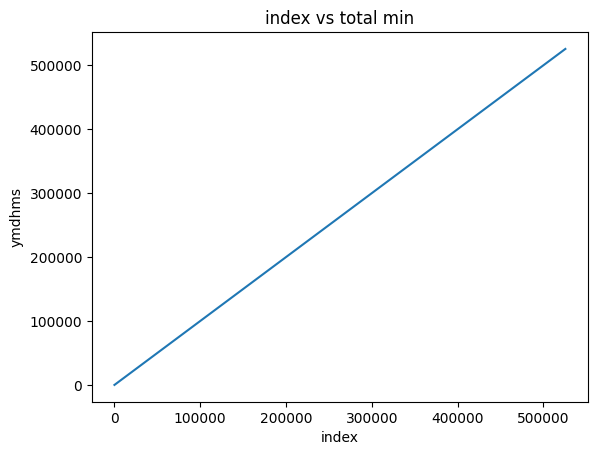

In [182]:
plt.plot(lev3['index'], lev3['total_minutes'])
plt.xlabel('index')
plt.ylabel('ymdhms')
plt.title('index vs total min')
plt.show()

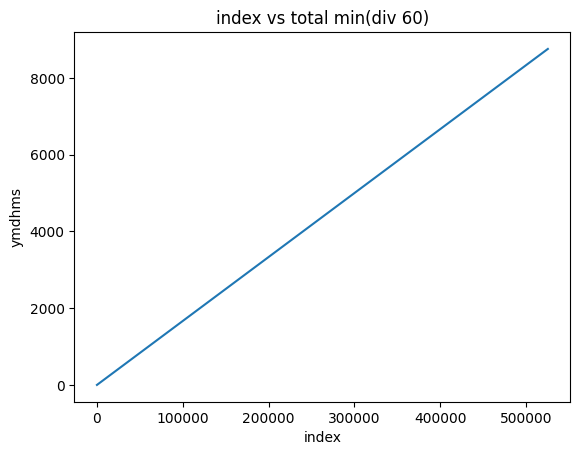

In [183]:
plt.plot(lev3['index'], lev3['total_minutes_sec'])
plt.xlabel('index')
plt.ylabel('ymdhms')
plt.title('index vs total min(div 60)')
plt.show()

In [184]:
#rotation
#drift

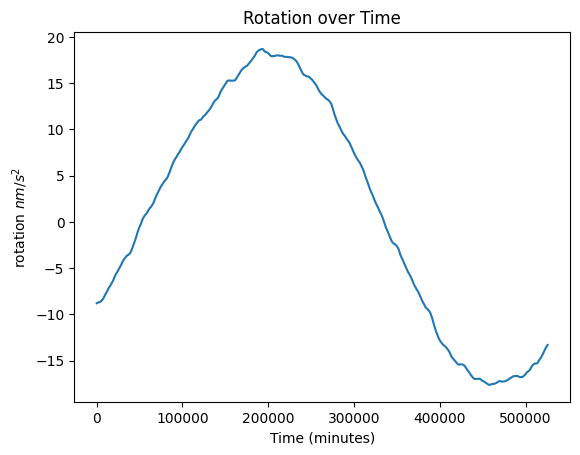

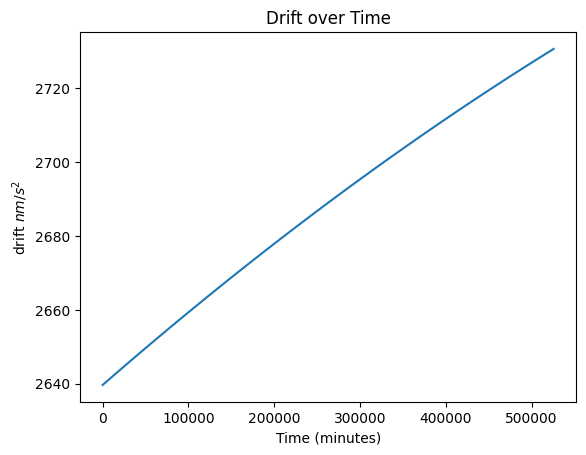

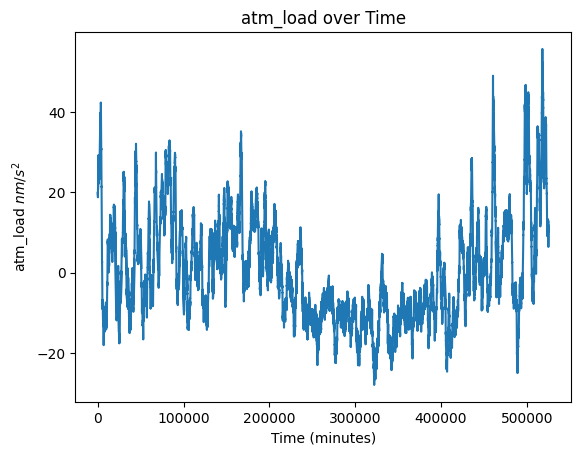

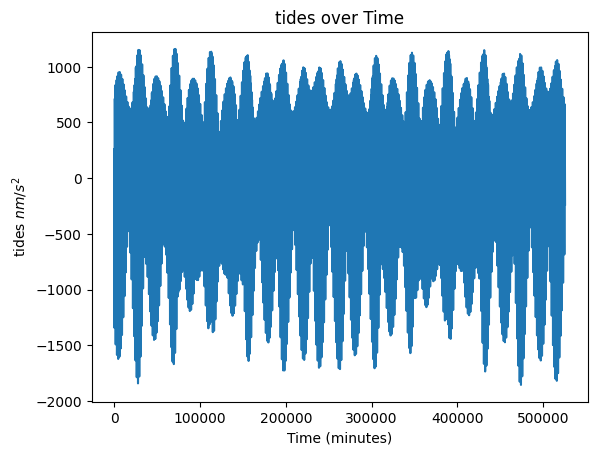

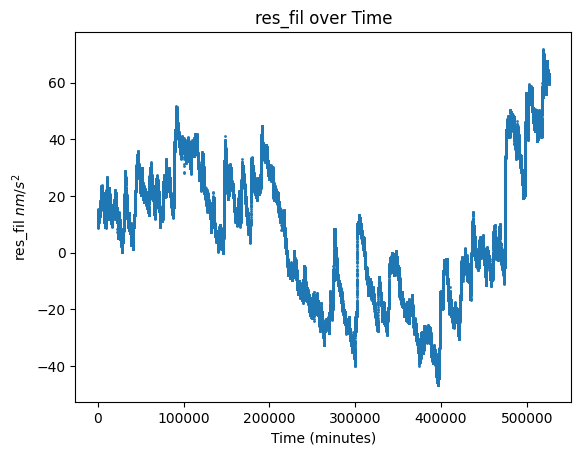

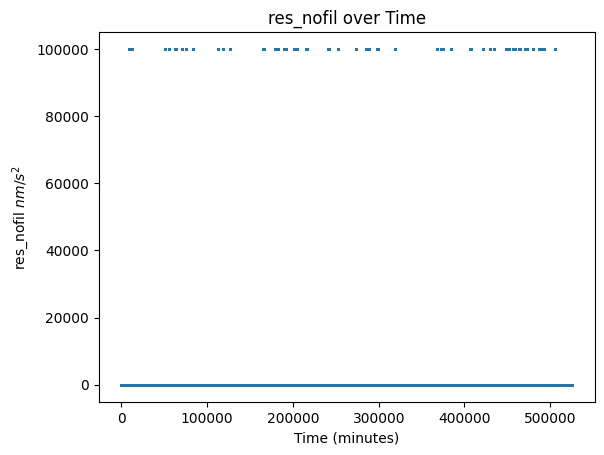

In [185]:
#rotation over time
plt.plot(lev3['total_minutes'], lev3['rotation'])
plt.xlabel('Time (minutes)')
plt.ylabel('rotation $nm/s^{2}$')
plt.title('Rotation over Time')
plt.show()

#drift over time
plt.plot(lev3['total_minutes'], lev3['drift'])
plt.xlabel('Time (minutes)')
plt.ylabel('drift $nm/s^{2}$')
plt.title('Drift over Time')
plt.show()

#atm_load over time
plt.plot(lev3['total_minutes'], lev3['atm_load'])
plt.xlabel('Time (minutes)')
plt.ylabel('atm_load $nm/s^{2}$')
plt.title('atm_load over Time')
plt.show()

#tides_load over time
plt.plot(lev3['total_minutes'], lev3['tides'])
plt.xlabel('Time (minutes)')
plt.ylabel('tides $nm/s^{2}$')
plt.title('tides over Time')
plt.show()

#res over time
plt.scatter(lev3['total_minutes'], lev3['res_fil'],s=1)
plt.xlabel('Time (minutes)')
plt.ylabel('res_fil $nm/s^{2}$')
plt.title('res_fil over Time')

plt.show()#res over time
plt.scatter(lev3['total_minutes'], lev3['res_nofil'],s=1)
plt.xlabel('Time (minutes)')
plt.ylabel('res_nofil $nm/s^{2}$')
plt.title('res_nofil over Time')
plt.show()

In [186]:
max_value = lev3['res_nofil'].max()

print(max_value)

99999.999


In [187]:
inde=lev3['total_minutes']
rota= lev3['rotation']
drif=lev3['drift']

In [188]:
from decimal import Decimal, getcontext

Fitting Equation: y = 0.00000288480800812483289248078048572221376844026963226497173309326171875x + 2642.21


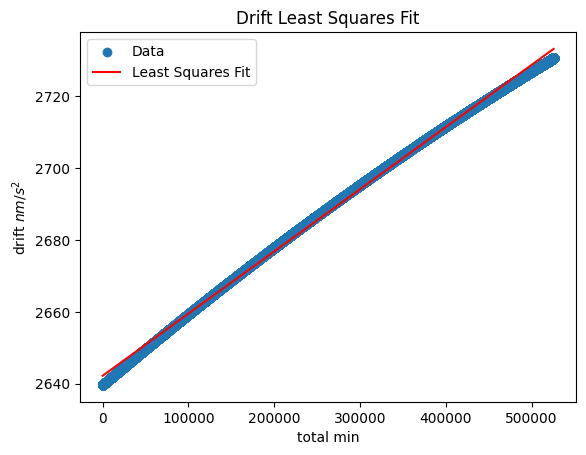

In [189]:
coefficients = np.polyfit(inde, drif, 1)

line = np.polyval(coefficients, inde)

slope = coefficients[0]
intercept = coefficients[1]

getcontext().prec = 4

if slope != 0:
    slope_str = str(Decimal(slope / 60))

print(f"Fitting Equation: y = {slope_str}x + {intercept:.2f}")

plt.scatter(inde, drif, label='Data')
plt.plot(inde, line, color='red', label='Least Squares Fit')
plt.xlabel('total min')
plt.ylabel('drift $nm/s^{2}$')
plt.title('Drift Least Squares Fit')
plt.legend()
plt.show()

In [190]:
###############################################################################################################################
#LOOOK HEREEEEEEEEEEEEE
#make the psd here larry
#kekw

In [191]:
#######
#making the psd

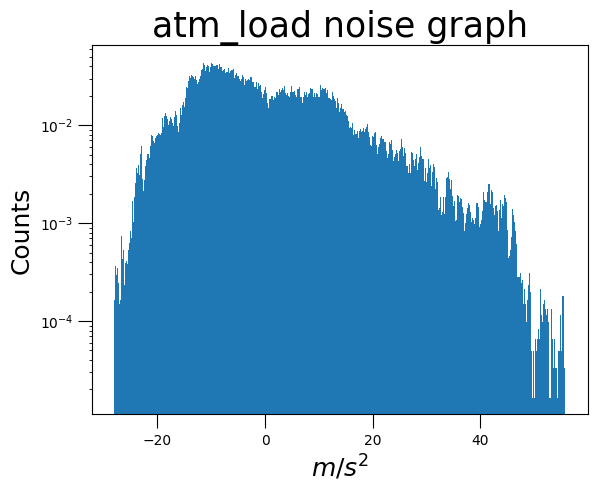

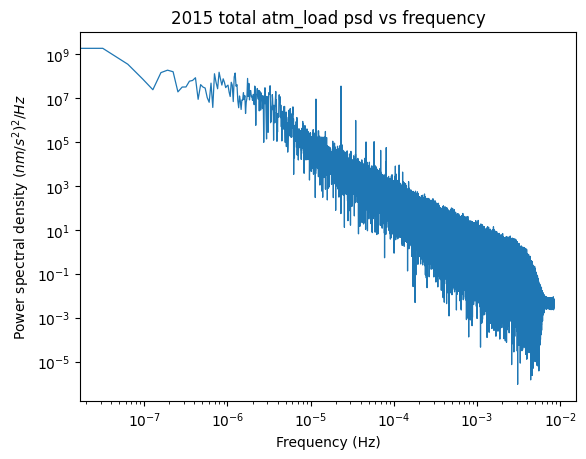

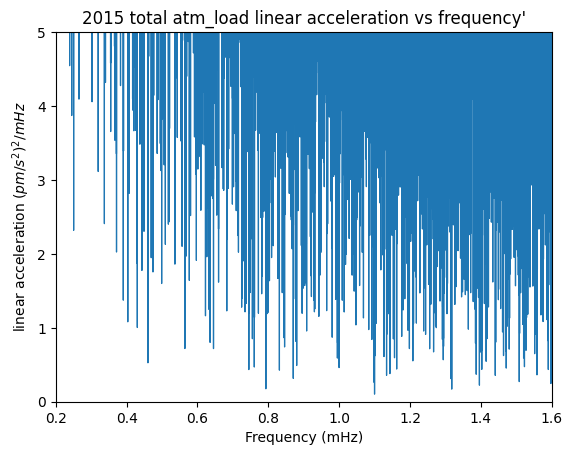

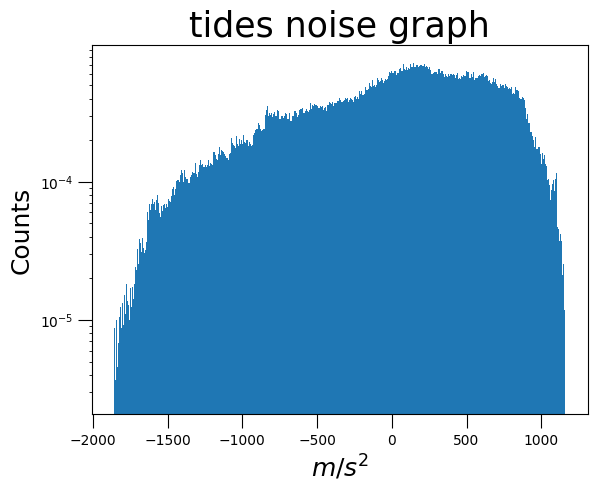

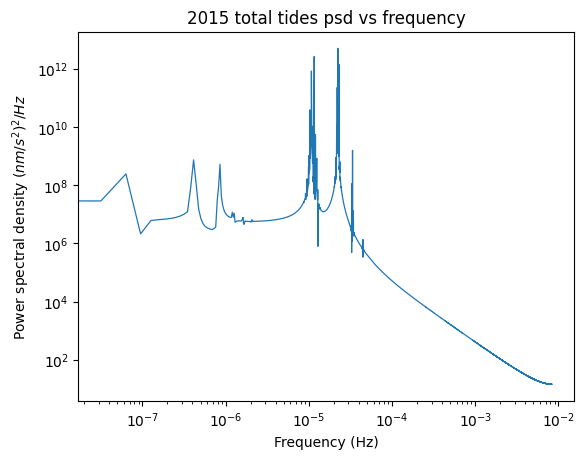

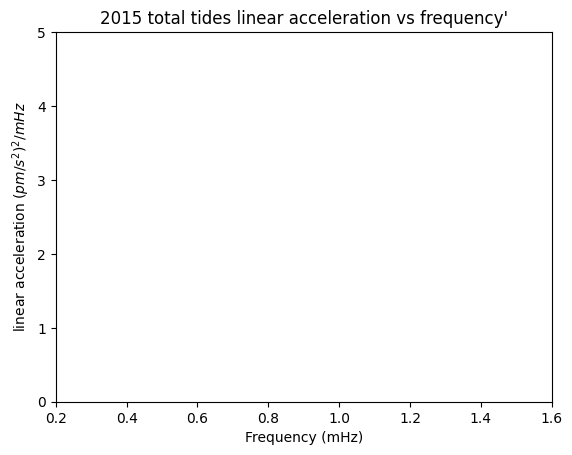

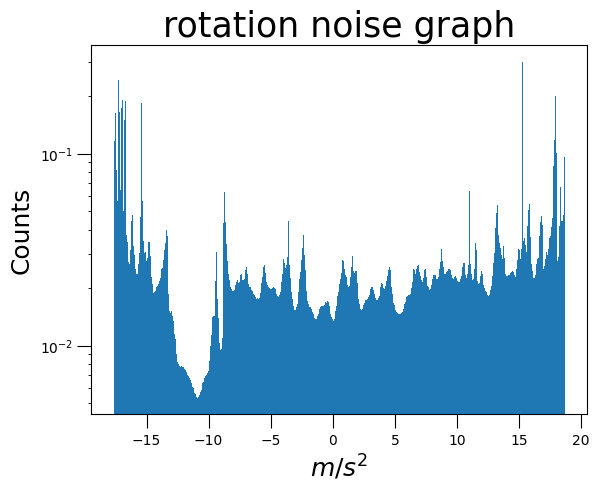

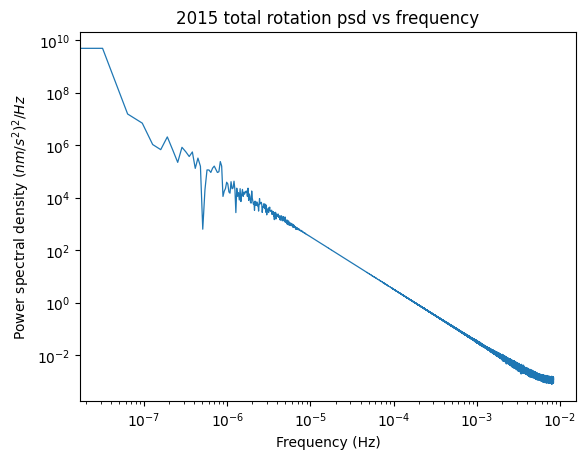

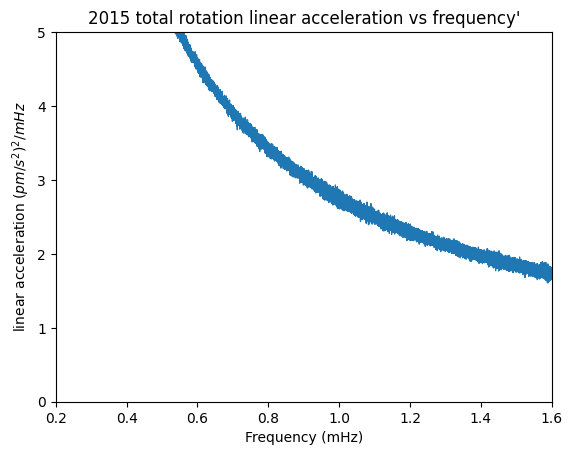

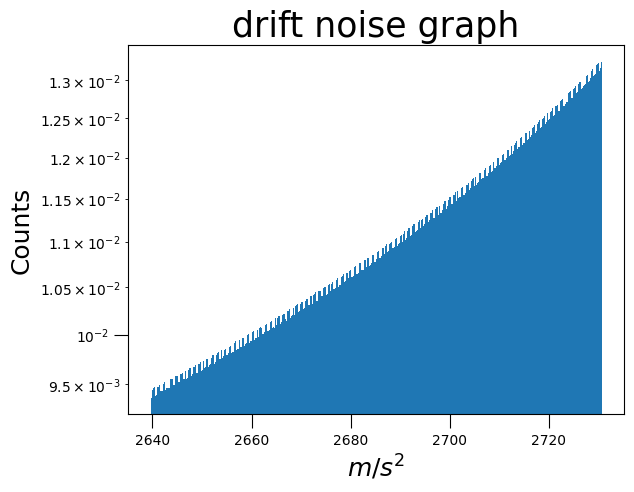

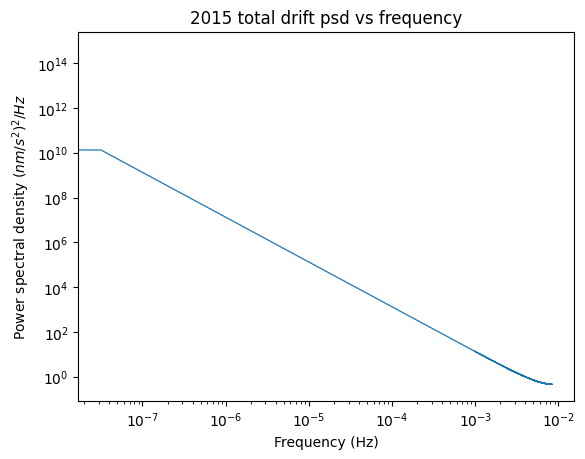

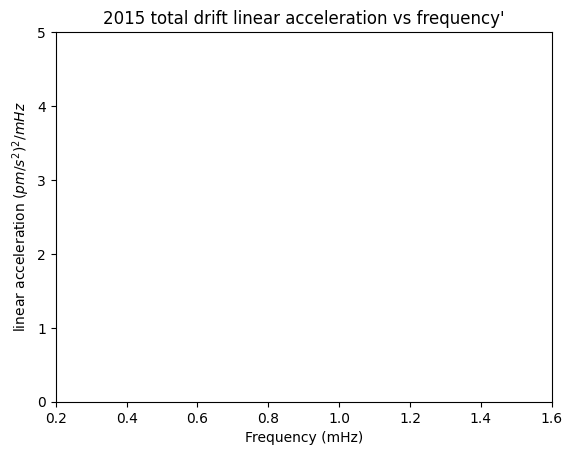

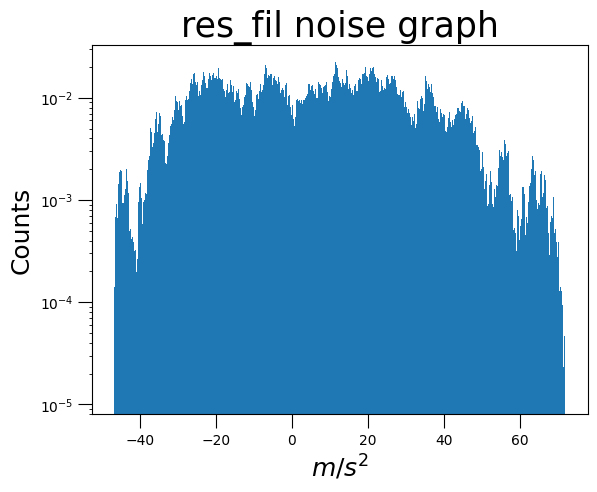

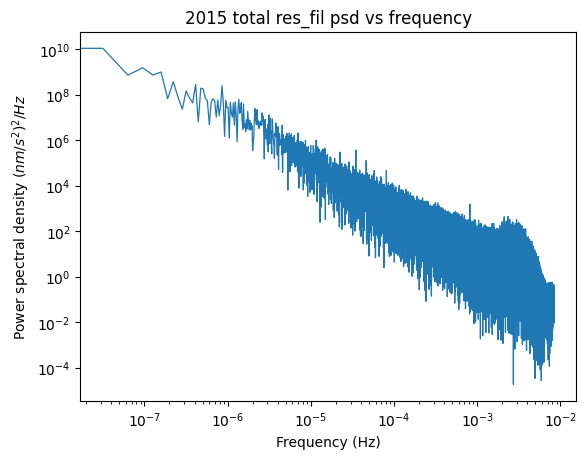

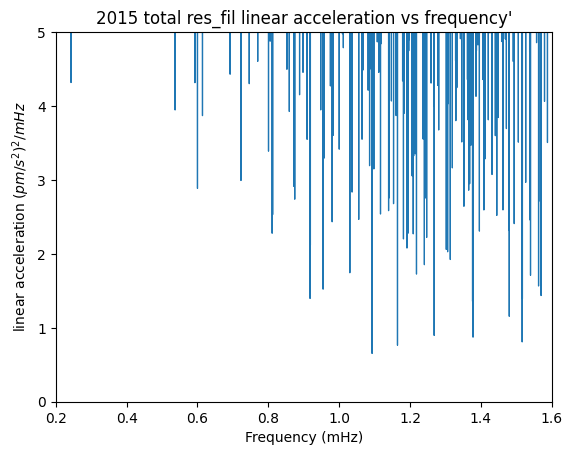

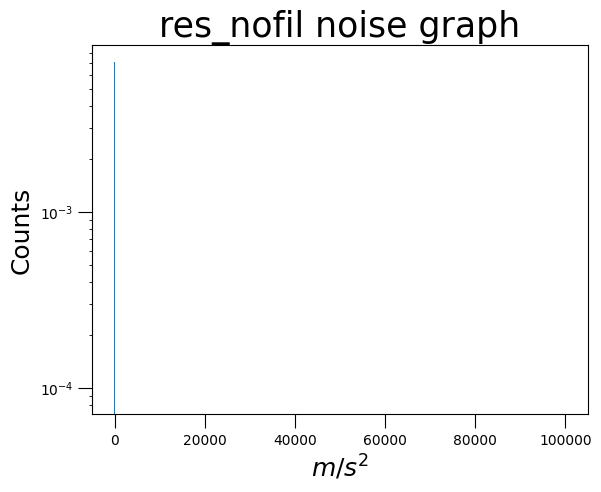

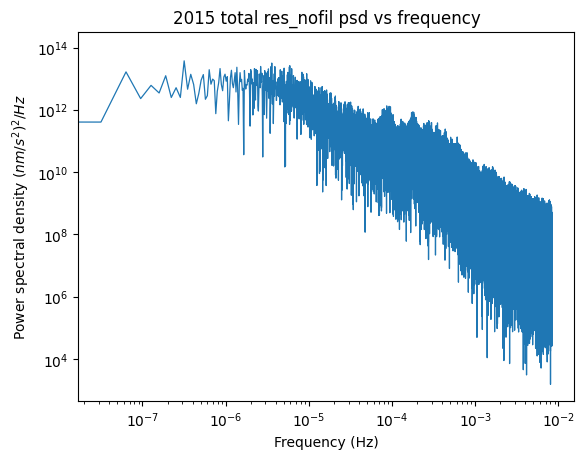

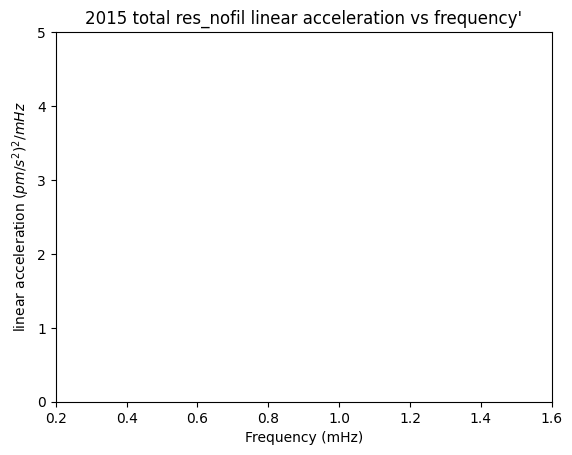

In [192]:
# List of signals
signals = [lev3['atm_load'], lev3['tides'], lev3['rotation'], lev3['drift'], lev3['res_fil'], lev3['res_nofil']]

# Iterate over each signal
for debil in signals:
    column_name = debil.name
    numBins = round(math.sqrt(len(debil)))
    
    ## Histogram
    fig, ax = plt.subplots()
    ax.hist(debil, bins=numBins, density=True, log=True)
    ax.set_xlabel("$m/s^{2}$", size=18)
    ax.set_ylabel("Counts", size=18)
    ax.set_title(f"{column_name} noise graph", size=25)
    ax.tick_params(axis='both', size=10)
    
    # making the PSD
    N = len(debil)  # number of measurements
    samplingRate = 1/60  # once per min sampling rate
    calibration_factor = -944.3833 * 1e-9  # sensitivity of accelerometer in nms^-2 per volt

    # compute the PSD
    #PSDV = np.abs(np.fft.rfft(debil))**2 / (N*samplingRate) #not useful anymore
    PSDG = (np.abs(np.fft.rfft(debil))**2) * 2 / (N*samplingRate)#normal psd
    #
    #here is the linear accelearion thing HERE IS THE LINEAR ACCELERAITON THING
    #
    PSDGL = (np.abs(np.fft.rfft(debil)))*2/(N*samplingRate)#linear acceleration in pm/s^2, which i remove the **2 (squared) after the rfft(debil), does that make sense?
    #
    #
    freq = np.fft.rfftfreq(N, d=1/samplingRate)

    # Plot PSDnormal
    fig, ax = plt.subplots()
    ax.plot(freq, PSDG, linewidth=0.9)

    #ax.plot([2.777e-4, 2.777e-4], [1e-10, 1e-18], 'k-', lw=1,dashes=[4, 4])
    #ax.plot([0.02, 0.02], [1e-10, 1e-18], 'k-', lw=1,dashes=[4, 4])

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"2015 total {column_name} psd vs frequency")
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$')

    # Plot PSD linear acceleartion
    fig, ax = plt.subplots()
    ax.plot(freq*1000, PSDGL*1000, linewidth=0.9)#1nm  = 1000pm, 1 hz = 1000 mhz (milihz?)
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlim(0.2,1.6)
    ax.set_ylim(0,5)
    ax.set_title(f"2015 total {column_name} linear acceleration vs frequency'")
    ax.set_xlabel('Frequency (mHz)')
    ax.set_ylabel('linear acceleration $(pm/s^{2})^{2}/mHz$')